# Parallel Tempering Demo

Parallel tempering (aka replica exchange) is a simulation method used to sample potential energy surfaces. Particularly at low temperatures, traditional Markov Chain Monte Carlo (MCMC) simulations are prone to getting "stuck" in local minima, failing to explore the entire surface. 

Parallel tempering rectifies this shortcoming by running multiple simulations in parallel at different temperatures. Systems then have some probability of swapping configurations with one another at a given step, allowing low temperature systems to escape local minima the way higher temperature systems may.

This demo seeks to provide a brief, qualitative demonstration of this.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from timeit import default_timer as timer

import ipywidgets as widgets
from IPython.display import display, clear_output

Consider the following potential energy function, with minima at $x \in \{-1.25, -0.25, 0.75, 1.75\}$:

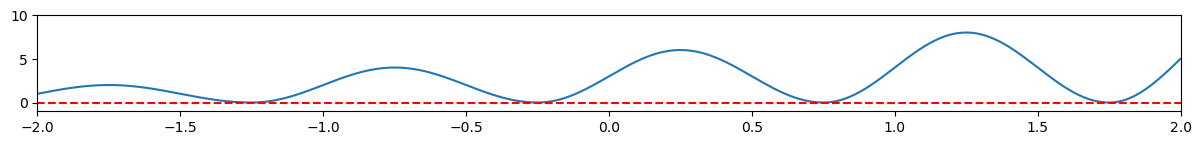

In [19]:
def U(x):
    tpx = 2*np.pi*x
    if x < -2: return float('inf')
    if x <= -1.25: return 1 + np.sin(tpx)
    if x <= -0.25: return 2*(1 + np.sin(tpx))
    if x <= 0.75: return 3*(1 + np.sin(tpx))
    if x <= 1.75: return 4*(1 + np.sin(tpx))
    if x <= 2: return 5*(1 + np.sin(tpx))
    return float('inf')

x = np.linspace(-2, 2, 1000)

plt.figure(figsize=(14.75, 1.25))
plt.plot(x, list(map(U, x)))
plt.plot(x, np.zeros(1000), '--r')
plt.xlim([-2, 2])
plt.ylim([-1, 10])
plt.show()

## Monte Carlo

We place a particle at $x=-1.25$, in the shallowest, leftmost well. Using the Monte Carlo widget below, simulate the probability distribution of the particle over time at various temperatures. What distribution do you observe? Is this distribution consistent with your intuition?

In [4]:
mc_plot_output = widgets.Output()

def mc_plot_histograms(poss):
    with mc_plot_output:
        clear_output(wait=True)
    
        mc_poss1, mc_poss2, mc_poss3 = poss
        x = np.linspace(-2, 2, 1000)
        fig, axs = plt.subplots(4, figsize=(12, 6), sharex=True)

        axs[0].hist(mc_poss3, density=True, bins=200, ls='dashed', lw=3, alpha=0.5, color='r')
        axs[0].set_title("T = 2.0 ", loc='right', pad=-14)
        axs[0].set_xlim([-2, 2])

        axs[1].hist(mc_poss2, density=True, bins=100, ls='dashed', lw=3, alpha=0.5, color='y')
        axs[1].set_title("T = 0.3 ", loc='right', pad=-14)
        axs[1].set_xlim([-2, 2])

        axs[2].hist(mc_poss1, density=True, bins=50, ls='dashed', lw=3, alpha=0.5, color='b')
        axs[2].set_title("T = 0.05 ", loc='right', pad=-14)
        axs[2].set_xlim([-2, 2])

        axs[3].plot(x, list(map(U, x)))
        axs[3].set_title("U(x) ", loc='right', pad=-14)
        axs[3].set_xlim([-2, 2])
        axs[3].set_ylim(0)

        fig.tight_layout()
        plt.show()

def monte_carlo(poss, MC_CYCLES):
    for _ in range(MC_CYCLES):
        row = np.random.randint(0, 3)
        curr = poss[row][-1]
        prop = curr + np.random.uniform(-0.1, 0.1)

        U_i, U_j = U(curr), U(prop)

        if U_j < U_i or np.random.rand() < np.exp((U_i - U_j)/[0.05, 0.3, 2.0][row]):
            curr = prop
        poss[row].append(curr)
    return poss

def update_monte_carlo(additional_cycles):
    global mc_poss1, mc_poss2, mc_poss3
    poss = mc_poss1, mc_poss2, mc_poss3
    mc_poss1, mc_poss2, mc_poss3 = monte_carlo(poss, additional_cycles)
    mc_plot_histograms(poss)

initial_cycles = 0  # Initial number of cycles
mc_poss1, mc_poss2, mc_poss3 = monte_carlo([[-1.25], [-1.25], [-1.25]], initial_cycles)  # Initial simulation

incr_button1 = widgets.Button(description="+1,000 cycles")
incr_button2 = widgets.Button(description="+10,000 cycles")
incr_button3 = widgets.Button(description="+100,000 cycles")
reset_button = widgets.Button(description="Reset Simulation")

def on_incr_button_clicked1(b):
    update_monte_carlo(1000)

def on_incr_button_clicked2(b):
    update_monte_carlo(10000)

def on_incr_button_clicked3(b):
    update_monte_carlo(100000)

def on_reset_button_clicked(b):
    global mc_poss1, mc_poss2, mc_poss3
    mc_poss1, mc_poss2, mc_poss3 = monte_carlo([[-1.25], [-1.25], [-1.25]], initial_cycles)
    update_monte_carlo(0)

incr_button1.on_click(on_incr_button_clicked1)
incr_button2.on_click(on_incr_button_clicked2)
incr_button3.on_click(on_incr_button_clicked3)
reset_button.on_click(on_reset_button_clicked)
display(
    widgets.VBox([
        widgets.HBox([incr_button1, incr_button2, incr_button3, reset_button]), 
        mc_plot_output
    ])
) 

# Initial plot
mc_plot_histograms([mc_poss1, mc_poss2, mc_poss3])

You should observe the following:

The densities for the lowest temperature of $T=0.05$ is localized near the starting point. There is some slight asymmetry in the peak, reflective of the asymmetry in the potential energy function that makes particles more likely to go left than right. 

At the temperature of $T=0.3$, the particle is still localized near the starting point, but it is able to climb higher up the energy barrier, reflected by the density becoming more diffuse. It also manages to cross over to the left local minimum briefly, though it still lacks the energy to go right. 

At the temperature of $T=2.0$, the particle now has enough energy to cross over all the potential barriers. Thus, it samples the four local minima roughly equally. The leftmost peak still appears slightly higher, indicating there is still some bias towards the initial starting point. The rightmost peak is the highest, because particles that enter that well have the hardest time getting out. There is some density at the left of the box but not the right because the left boundary of the box is a local minimum while the right boundary is not. 

## Parallel Tempering

Now, perform the same simulation but using the widget below, which has been implemented using parallel tempering. What distribution do you observe? Is this distribution consistent with your intuition?

In [5]:
pt_plot_output = widgets.Output()

def pt_plot_histograms(poss):
    with pt_plot_output:
        clear_output(wait=True)
    
        pt_poss1, pt_poss2, pt_poss3 = poss
        x = np.linspace(-2, 2, 1000)
        fig, axs = plt.subplots(4, figsize=(12, 6), sharex=True)

        axs[0].hist(pt_poss3, density=True, bins=200, ls='dashed', lw=3, alpha=0.5, color='r')
        axs[0].set_title("T = 2.0 ", loc='right', pad=-14)
        axs[0].set_xlim([-2, 2])

        axs[1].hist(pt_poss2, density=True, bins=100, ls='dashed', lw=3, alpha=0.5, color='y')
        axs[1].set_title("T = 0.3 ", loc='right', pad=-14)
        axs[1].set_xlim([-2, 2])

        axs[2].hist(pt_poss1, density=True, bins=50, ls='dashed', lw=3, alpha=0.5, color='b')
        axs[2].set_title("T = 0.05 ", loc='right', pad=-14)
        axs[2].set_xlim([-2, 2])

        axs[3].plot(x, list(map(U, x)))
        axs[3].set_title("U(x) ", loc='right', pad=-14)
        axs[3].set_xlim([-2, 2])
        axs[3].set_ylim(0)

        fig.tight_layout()
        plt.show()

def parallel_tempering(poss, MC_CYCLES):
    for i in range(MC_CYCLES):
        if np.random.rand() < 0.9: # displacement
            row = np.random.randint(0, 3)
            curr = poss[row][-1]
            prop = curr + np.random.uniform(-0.1, 0.1)

            U_i, U_j = U(curr), U(prop)
            if U_j < U_i or np.random.rand() < np.exp((U_i - U_j)/[0.05, 0.3, 2.0][row]):
                curr = prop
            poss[row].append(curr)
        else: # hamiltonian
            n1 = np.random.randint(0, 2)
            n2 = n1+1
            
            beta1, beta2 = 1/[0.05, 0.3, 2.0][n1], 1/[0.05, 0.3, 2.0][n2]
            zeta = np.exp((beta2 - beta1)*(U(poss[n2][-1]) - U(poss[n1][-1])))
            
            if np.random.rand() < min(1, zeta):
                poss[n1][-1], poss[n2][-1] = poss[n2][-1], poss[n1][-1]

    return poss

def update_parallel_tempering(additional_cycles):
    global pt_poss1, pt_poss2, pt_poss3
    poss = pt_poss1, pt_poss2, pt_poss3
    pt_poss1, pt_poss2, pt_poss3 = parallel_tempering(poss, additional_cycles)
    pt_plot_histograms(poss)

initial_cycles = 0  # Initial number of cycles
pt_poss1, pt_poss2, pt_poss3 = parallel_tempering([[-1.25], [-1.25], [-1.25]], initial_cycles)  # Initial simulation

incr_button1 = widgets.Button(description="+1,000 cycles")
incr_button2 = widgets.Button(description="+10,000 cycles")
incr_button3 = widgets.Button(description="+100,000 cycles")
reset_button = widgets.Button(description="Reset Simulation")

def on_incr_button_clicked1(b):
    update_parallel_tempering(1000)

def on_incr_button_clicked2(b):
    update_parallel_tempering(10000)

def on_incr_button_clicked3(b):
    update_parallel_tempering(100000)

def on_reset_button_clicked(b):
    global pt_poss1, pt_poss2, pt_poss3
    pt_poss1, pt_poss2, pt_poss3 = parallel_tempering([[-1.25], [-1.25], [-1.25]], initial_cycles)
    update_parallel_tempering(0)

incr_button1.on_click(on_incr_button_clicked1)
incr_button2.on_click(on_incr_button_clicked2)
incr_button3.on_click(on_incr_button_clicked3)
reset_button.on_click(on_reset_button_clicked)
display(
    widgets.VBox([
        widgets.HBox([incr_button1, incr_button2, incr_button3, reset_button]), 
        pt_plot_output
    ])
) 

# Initial plot
pt_plot_histograms([pt_poss1, pt_poss2, pt_poss3])

You should observe the following:

For $T = 2.0$, the distribution is largely unchanged. This makes sense as the temperature of the system is already high enough to sample every position. 

For $T = 0.3$, the distribution now has peaks at every local minima. This is because, during some iterations, it can exchange with the $T = 2.0$ system, which is likely to be near another local minima, allowing it to then make displacement moves around that minima as well. We see about the same density near the metastable $x=-2.0$ state. I'm not exactly sure why this is the case, but it could be because the $T = 0.3$ system is more likely to go towards the right, since the rightmost peak of the $T = 2.0$ state is the most likely and, if it does go left, it will quickly swap out of that state. 

For $T = 0.05$, similar to the $T = 0.3$ distribution, we now see peaks at every zero. This is because it can exchange with the $T = 0.3$ system, which now can sample all local minima. However, we still do not see density near the metastable state, because the $T = 0.3$ has negligible density in that area.